In [ ]:
import numpy as np
import pandas as pd
import math
from scipy.stats import loguniform
from statistics import mean
from scipy import stats
import seaborn as sns
#import scikit_posthocs
import warnings 

from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.metrics import classification_report,f1_score
from sklearn.impute import SimpleImputer 
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
#from scikit_posthocs import posthoc_nemenyi_friedman

warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv('heart.csv')
df

In [3]:
df.shape

(918, 12)

In [4]:
a=df.dtypes
a

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

In [5]:
df.describe()
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


In [6]:
#from the above there is no datatype object that condradicts with the above description

# we splitted the dataset based on feature type=categorical and numeric. 
allFeatures=df.columns[1:len(df.columns)-1]
catFeatures=[]
for i in range((len(df.columns)-1)):
    if df.dtypes[i]=='O':
        print(i)
        catFeatures.append(i)
catFeatures.append(5) #fasting bs is categorical 1: if FastingBS > 120 mg/dl, 0: otherwise

catFeatures=df.columns[catFeatures]
print(catFeatures)

numFeatures= [i for i in allFeatures if not(i in catFeatures)]
print(numFeatures)

1
2
6
8
10
Index(['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope',
       'FastingBS'],
      dtype='object')
['RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']


In [7]:
df[numFeatures].describe()
#get rid of min resting bp or data points that are insignificant.

,RestingBP,Cholesterol,MaxHR,Oldpeak
count,918.000000,918.000000,918.000000,918.000000
mean,132.396514,198.799564,136.809368,0.887364
std,18.514154,109.384145,25.460334,1.066570
min,0.000000,0.000000,60.000000,-2.600000
25%,120.000000,173.250000,120.000000,0.000000
50%,130.000000,223.000000,138.000000,0.600000
75%,140.000000,267.000000,156.000000,1.500000
max,200.000000,603.000000,202.000000,6.200000


In [8]:
s=0
c= np.where(df['RestingBP']==0)
print(c[0])
df.iloc[449]

[449]


Age                   55
Sex                    M
ChestPainType        NAP
RestingBP              0
Cholesterol            0
FastingBS              0
RestingECG        Normal
MaxHR                155
ExerciseAngina         N
Oldpeak              1.5
ST_Slope            Flat
HeartDisease           1
Name: 449, dtype: object

In [9]:
df=df.drop(index=449,axis=0) #removed this index because it has resting BP. and Cholestrol zero


In [10]:
df=df.reset_index()
df=df.drop(['index'],axis=1)
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
912,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
913,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
914,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
915,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


array([[<AxesSubplot:title={'center':'RestingBP'}>,
        <AxesSubplot:title={'center':'Cholesterol'}>],
       [<AxesSubplot:title={'center':'MaxHR'}>,
        <AxesSubplot:title={'center':'Oldpeak'}>]], dtype=object)

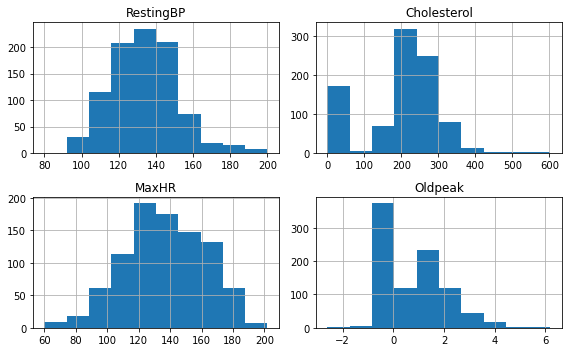

In [11]:
plt.rcParams["figure.figsize"] = [8, 5]
plt.rcParams["figure.autolayout"] = True
df[numFeatures].hist()


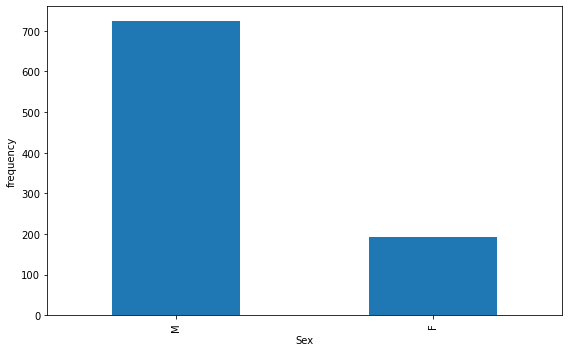

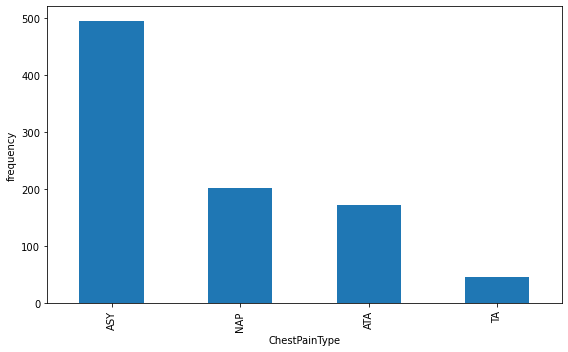

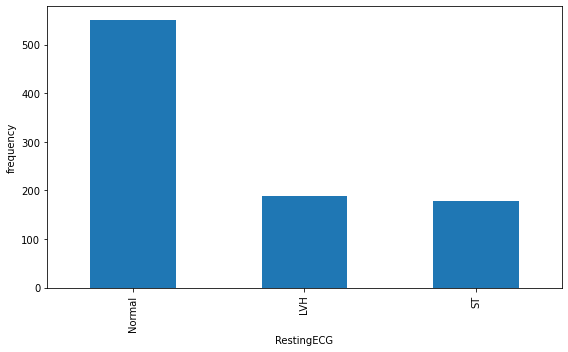

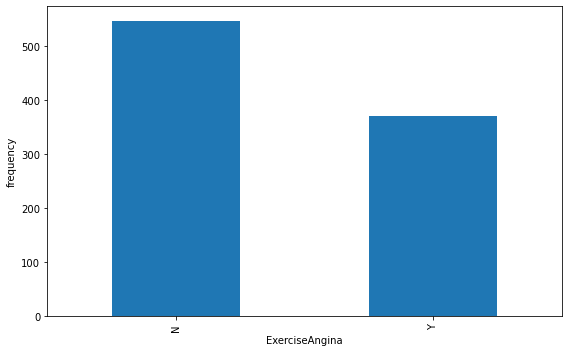

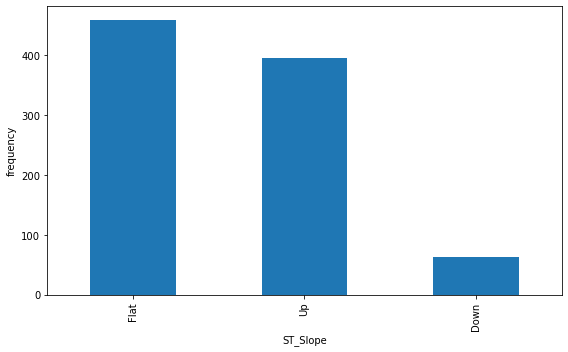

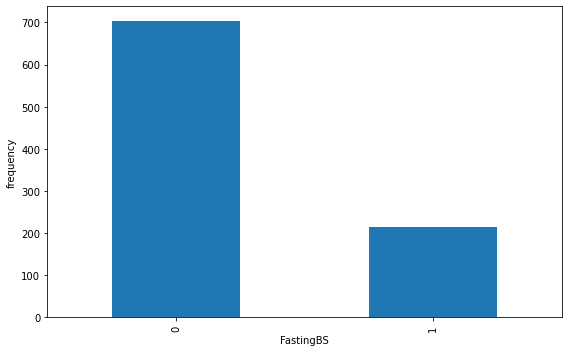

In [12]:
for cat in catFeatures:
    fig, ax = plt.subplots()
    df[cat].value_counts().plot(ax=ax, kind='bar', xlabel=cat, ylabel='frequency')
    plt.show()

In [13]:
for i in catFeatures:
    a=df[i].describe()
    print('Describe for '+ str(i))
    print(a)

Describe for Sex
count     917
unique      2
top         M
freq      724
Name: Sex, dtype: object
Describe for ChestPainType
count     917
unique      4
top       ASY
freq      496
Name: ChestPainType, dtype: object
Describe for RestingECG
count        917
unique         3
top       Normal
freq         551
Name: RestingECG, dtype: object
Describe for ExerciseAngina
count     917
unique      2
top         N
freq      546
Name: ExerciseAngina, dtype: object
Describe for ST_Slope
count      917
unique       3
top       Flat
freq       459
Name: ST_Slope, dtype: object
Describe for FastingBS
count    917.000000
mean       0.233370
std        0.423206
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: FastingBS, dtype: float64


In [14]:
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [15]:
#Compute Pearson pairwise correlation of features
corr_matrix=df[numFeatures].corr()
print(corr_matrix)

             RestingBP  Cholesterol     MaxHR   Oldpeak
RestingBP     1.000000     0.089392 -0.109693  0.174252
Cholesterol   0.089392     1.000000  0.237705  0.051390
MaxHR        -0.109693     0.237705  1.000000 -0.161213
Oldpeak       0.174252     0.051390 -0.161213  1.000000


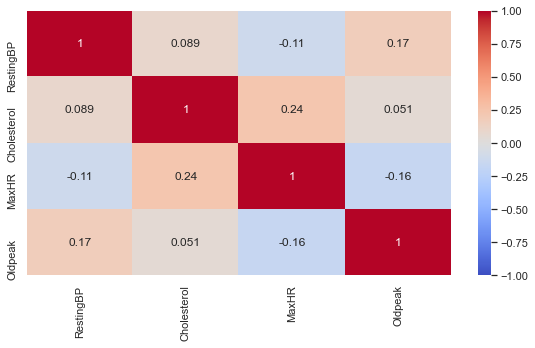

In [16]:
#Visualize Pearson pairwise correlation of features
fig = plt.figure()
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.heatmap(corr_matrix,cmap='coolwarm', vmin=-1, vmax=1,annot = True)
plt.xticks(rotation=90)
ax.set_xticklabels(df[numFeatures].columns)
ax.set_yticklabels(df[numFeatures].columns)
plt.show()

In [17]:
numFeatures.append('HeartDisease')
numFeatures

['RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak', 'HeartDisease']

In [18]:
corr_matrix=df[numFeatures].corr()
print(corr_matrix)

              RestingBP  Cholesterol     MaxHR   Oldpeak  HeartDisease
RestingBP      1.000000     0.089392 -0.109693  0.174252      0.117990
Cholesterol    0.089392     1.000000  0.237705  0.051390     -0.231479
MaxHR         -0.109693     0.237705  1.000000 -0.161213     -0.401410
Oldpeak        0.174252     0.051390 -0.161213  1.000000      0.403638
HeartDisease   0.117990    -0.231479 -0.401410  0.403638      1.000000


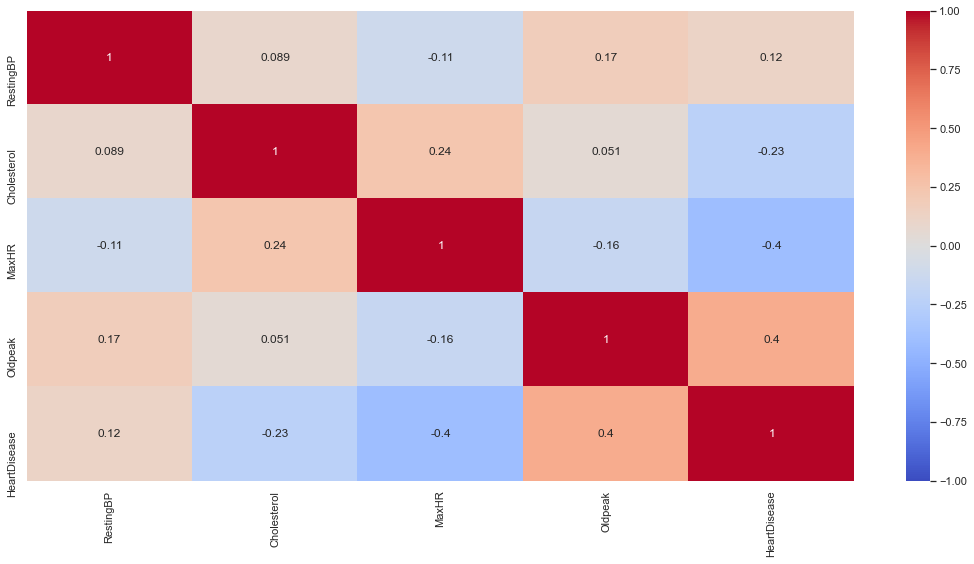

In [19]:
#Visualize Pearson pairwise correlation of features
fig = plt.figure()
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.heatmap(corr_matrix,cmap='coolwarm', vmin=-1, vmax=1,annot = True)
plt.xticks(rotation=90)
ax.set_xticklabels(df[numFeatures].columns)
ax.set_yticklabels(df[numFeatures].columns)
plt.show()

In [20]:
#Remove Cholesterol variable
df = df.drop(labels = "Cholesterol", axis = 1)
df.head()

,Age,Sex,ChestPainType,RestingBP,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,0,Normal,122,N,0.0,Up,0


In [21]:
allFeatures=df.columns[1:len(df.columns)-1]
catFeatures=[]
for i in range((len(df.columns)-1)):
    if df.dtypes[i]=='O':
        print(i)
        catFeatures.append(i)
catFeatures.append(5) #fasting bs is categorical 1: if FastingBS > 120 mg/dl, 0: otherwise

catFeatures=df.columns[catFeatures]
print(catFeatures)

numFeatures= [i for i in allFeatures if not(i in catFeatures)]
print(numFeatures)

1
2
5
7
9
Index(['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope',
       'RestingECG'],
      dtype='object')
['RestingBP', 'FastingBS', 'MaxHR', 'Oldpeak']


In [22]:
df[allFeatures]

,Sex,ChestPainType,RestingBP,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
0,M,ATA,140,0,Normal,172,N,0.0,Up
1,F,NAP,160,0,Normal,156,N,1.0,Flat
2,M,ATA,130,0,ST,98,N,0.0,Up
3,F,ASY,138,0,Normal,108,Y,1.5,Flat
4,M,NAP,150,0,Normal,122,N,0.0,Up
...,...,...,...,...,...,...,...,...,...
912,M,TA,110,0,Normal,132,N,1.2,Flat
913,M,ASY,144,1,Normal,141,N,3.4,Flat
914,M,ASY,130,0,Normal,115,Y,1.2,Flat
915,F,ATA,130,0,LVH,174,N,0.0,Flat


In [23]:
X_train, X_test, y_train, y_test = train_test_split(df[allFeatures], df["HeartDisease"], test_size=0.20, random_state=42)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(df[allFeatures], df["HeartDisease"], test_size = 0.2, random_state=42, stratify=df["HeartDisease"])

In [25]:
y_df = pd.DataFrame(y_train)
count = 0
for i in range(len(y_df)):
    if (y_df.values[i].item() == 0):
        count = count + 1

count

328

In [26]:
y_df = pd.DataFrame(y_test)
count = 0
for i in range(len(y_df)):
    if (y_df.values[i].item() == 0):
        count = count + 1

count

82

In [27]:
328/len(y_train)

0.44747612551159616

In [28]:
82/len(y_test)

0.44565217391304346

In [29]:
len(X_train)

733

In [30]:
train = pd.concat([X_train, y_train], axis=1)
train = train.reset_index(drop=True)
train

,Sex,ChestPainType,RestingBP,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,M,ASY,128,0,Normal,96,Y,0.0,Flat,1
1,M,NAP,134,1,Normal,151,Y,0.0,Up,0
2,M,NAP,126,1,Normal,134,N,2.2,Flat,1
3,M,ASY,125,1,Normal,163,N,0.2,Flat,1
4,M,ASY,160,0,Normal,94,Y,2.5,Flat,1
...,...,...,...,...,...,...,...,...,...,...
728,M,NAP,135,0,Normal,150,N,2.0,Flat,1
729,M,NAP,120,0,Normal,150,N,0.0,Up,0
730,M,NAP,131,0,Normal,128,Y,2.0,Down,1
731,M,ASY,125,0,ST,115,Y,0.0,Up,0


In [31]:
# 4. Using bootstrapping method, create 50 in-bag (training and validation) with the size of data, 
# and related 50 out-of-bag or testing.
samples_in_bag = []
samples_out_bag = []
# There are 733 total samples = 733 indicies
indices = list(range(1, len(train[allFeatures])))

for i in range(50):
    out_bag_indicies = []
    if i == 0:
        # all indices in the dataset
        Index=range(0,int(len(train[allFeatures])))
        # Resamples the array of indicies. Random state is needed for the first bootstrap to generate different 
        # bootstraps
        S1 = resample(Index, replace=True, n_samples=len(Index), random_state=1)
        # appends to the samples in the array of in bags bootstraps
        samples_in_bag.append(set(S1))
    else:
        # all indices in the dataset
        Index=range(0,int(len(train[allFeatures])))
        # Resamples the array of indicies.
        S1 = resample(Index, replace=True, n_samples=len(Index))
        # appends to the samples in the array of in bags bootstraps
        samples_in_bag.append(set(S1))
        
    # places the non-selected indicies into an out of bag bootstrap
    # goes through all the indices
    for j in range(len(indices)):
        if indices[j] not in samples_in_bag[i]:
            out_bag_indicies.append(j)
    # appends to the array of out bags bootstraps
    samples_out_bag.append(out_bag_indicies)
    
# out of bag observations percentages of total data
for i in range(50):
    print(len(samples_out_bag[i])/len(indices)*100.0) # out of bag 
    # prints number of samples in one out of bag bootstrap, and prints number of samples in one in bag bootstrap
    print(len(samples_out_bag[i]),len(samples_in_bag[i]))

36.33879781420765
266 467
36.6120218579235
268 465
35.24590163934426
258 475
36.6120218579235
268 465
35.65573770491803
261 471
37.43169398907104
274 458
37.43169398907104
274 459
36.20218579234973
265 468
36.33879781420765
266 467
37.43169398907104
274 459
37.15846994535519
272 460
38.3879781420765
281 452
35.65573770491803
261 472
37.97814207650273
278 455
38.52459016393443
282 451
35.51912568306011
260 473
35.92896174863388
263 470
37.02185792349727
271 461
37.43169398907104
274 458
35.92896174863388
263 470
36.0655737704918
264 468
35.10928961748634
257 475
37.02185792349727
271 462
37.15846994535519
272 460
37.43169398907104
274 458
35.38251366120219
259 473
37.84153005464481
277 456
35.65573770491803
261 472
37.97814207650273
278 455
36.47540983606557
267 465
35.92896174863388
263 470
38.52459016393443
282 451
38.25136612021858
280 452
37.15846994535519
272 460
37.84153005464481
277 456
34.97267759562842
256 476
37.295081967213115
273 460
38.52459016393443
282 451
36.065573770491

In [32]:
# Use sklearn StandardScaler to scale numeric features
# Standardized features by removing the mean and scaling to unit variance
array_of_pds_train = []
array_of_pds_test = []
train_y_arr = []
test_y_arr = []

for i in range(len(samples_in_bag)):
    # get the one in bag bootstrap and one out of bag bootstrap
    sample_in = samples_in_bag[i]
    sample_out = samples_out_bag[i]

    # create scalor object
    scalor=StandardScaler()
    
    # select the subset from data that corresponds to specific in bag bootstrap
    df_train = train[numFeatures].loc[sample_in, :]
    # select the subset from data that corresponds to specific out of bag bootstrap
    df_test = train[numFeatures].loc[sample_out, :]
    # select the subset of the categorical variable that corresponds to specific in bag Bootstrap 
    df_train_char = train[catFeatures].loc[sample_in]
    df_train_char = df_train_char.reset_index(drop=True)
    # select the subset of the categorical variable that corresponds to specific out of bag Bootstrap 
    df_test_char = train[catFeatures].loc[sample_out]
    df_test_char = df_test_char.reset_index(drop = True)
    # select the subset of the target that corresponds to specific in bag bootstrap
    train_y = train['HeartDisease'].loc[sample_in].to_numpy()
    # select the subset of the target that corresponds to specific out of bag bootstrap
    test_y = train['HeartDisease'].loc[sample_out].to_numpy()
    
    # Computes the mean and std of the data
    scalor.fit(df_train)
    # Performs standardization on the training set and testing set
    df_train=scalor.transform(df_train)
    df_test=scalor.transform(df_test)
    #places resulting values into a dataframe
    df_train = pd.DataFrame(df_train, columns=numFeatures)
    df_test = pd.DataFrame(df_test, columns=numFeatures)
    
    # attach the categorical variables to the dataframes
    df_train_allF = pd.concat([df_train, df_train_char], axis=1)
    df_test_allF = pd.concat([df_test, df_test_char], axis = 1)
    #df_train[catFeatures] = df_train_char
    #df_test[catFeatures] = df_test_char
    
    # creates an array of training dataframes that have subsets from each bootstrap
    array_of_pds_train.append(df_train_allF)
    # creates an array of testing dataframes that have subsets from each bootstrap
    array_of_pds_test.append(df_test_allF)
    # creates an array of y values for the training data that have subsets from each bootstrap
    train_y_arr.append(train_y)
    # creates an array of y values for the testing data that have subsets from each bootstrap
    test_y_arr.append(test_y) 

In [33]:
# Encode all possible categorical data using get_dummies
for i in range(len(array_of_pds_train)):
    array_of_pds_train[i] = pd.get_dummies(array_of_pds_train[i])
    array_of_pds_test[i] = pd.get_dummies(array_of_pds_test[i])